In [545]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [546]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [547]:
NUM_CLASSES = 25

# Dataset reading

In [548]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2*2) + 1)))

In [549]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [550]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [551]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2*2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [552]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_54 (Dropout)        (None, 84)                0         
                                                                 
 dense_81 (Dense)            (None, 30)                2550      
                                                                 
 dropout_55 (Dropout)        (None, 30)                0         
                                                                 
 dense_82 (Dense)            (None, 20)                620       
                                                                 
 dense_83 (Dense)            (None, 25)                525       
                                                                 
Total params: 3,695
Trainable params: 3,695
Non-trainable params: 0
_________________________________________________________________


In [553]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [554]:
# Model compilation
model.compile(
    optimizer='adam',
    #loss='mean_squared_error',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [555]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=256,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
46/66 [===================>..........] - ETA: 0s - loss: 3.1910 - accuracy: 0.0760
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
66/66 [==============================] - 1s 7ms/step - loss: 3.1282 - accuracy: 0.1013 - val_loss: 2.8289 - val_accuracy: 0.2140
Epoch 2/1000
59/66 [=========================>....] - ETA: 0s - loss: 2.6750 - accuracy: 0.2144
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
66/66 [==============================] - 0s 4ms/step - loss: 2.6533 - accuracy: 0.2171 - val_loss: 2.1739 - val_accuracy: 0.3214
Epoch 3/1000
65/66 [============================>.] - ETA: 0s - loss: 2.1422 - accuracy: 0.3344
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
66/66 [==============================] - 0s 4ms/step - loss: 2.1401 - accuracy: 0.3346 - val_loss: 1.5544 - val_accuracy: 0.5689
Epoch 4/1000
63/66 [===========================>..] - ETA: 0s - loss: 1.7449 - accuracy: 0.4327
E

In [556]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

44/44 [==============================] - 0s 1ms/step - loss: 0.0241 - accuracy: 0.9988


In [557]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [558]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 94ms/step
[8.3574747e-08 1.0163761e-12 2.0500717e-09 7.8739312e-08 7.0660433e-05
 2.8745517e-13 1.1602903e-13 5.2600524e-13 8.6588853e-18 1.0584858e-03
 1.0463150e-10 2.0582863e-14 1.6871727e-13 1.8154370e-07 4.7547935e-08
 2.2179653e-18 3.0702333e-21 2.0158805e-12 4.8193814e-16 2.7939418e-15
 1.7083119e-16 1.2146841e-22 9.9887055e-01 6.6263234e-10 2.4466802e-12]
22


# Confusion matrix

176/176 [==============================] - 0s 895us/step


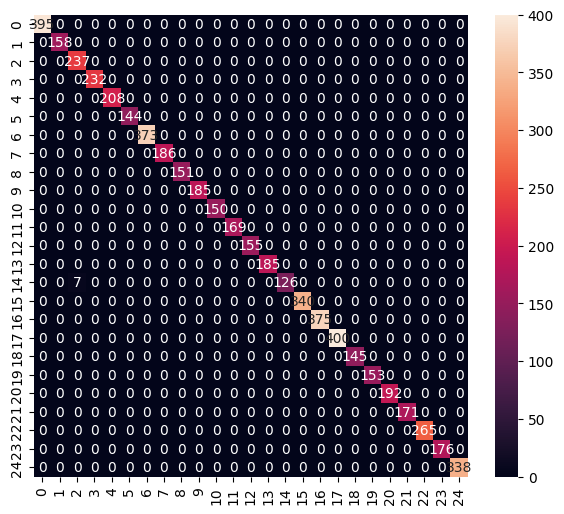

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       395
           1       1.00      1.00      1.00       158
           2       0.97      1.00      0.99       237
           3       1.00      1.00      1.00       232
           4       1.00      1.00      1.00       208
           5       1.00      1.00      1.00       144
           6       1.00      1.00      1.00       373
           7       1.00      1.00      1.00       186
           8       1.00      1.00      1.00       151
           9       1.00      1.00      1.00       185
          10       1.00      1.00      1.00       150
          11       1.00      1.00      1.00       169
          12       1.00      1.00      1.00       155
          13       1.00      1.00      1.00       185
          14       1.00      0.95      0.97       133
          15       1.00      1.00      1.00       340
          16       1.00      1.00      1.00       375
     

In [559]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [560]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [561]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\jonas\AppData\Local\Temp\tmptjec_s6r\assets


INFO:tensorflow:Assets written to: C:\Users\jonas\AppData\Local\Temp\tmptjec_s6r\assets


9488

# Inference test

In [562]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [563]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [564]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [565]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [566]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.47806786e-08 9.95108835e-13 2.27932984e-09 1.06475575e-07
 8.61587032e-05 3.42105901e-13 1.29924798e-13 5.01987612e-13
 5.78016441e-18 1.20465131e-03 9.90988333e-11 1.84788555e-14
 1.20794339e-13 1.79593883e-07 5.91326241e-08 1.52291623e-18
 2.04793703e-21 2.15813782e-12 3.42759188e-16 2.20674868e-15
 1.04804756e-16 1.12620749e-22 9.98708725e-01 5.38351586e-10
 2.75234674e-12]
22
